#### Import Libraries

In [17]:
import joblib
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#### Load and preprare the data

In [2]:
# Load the dataset
data = pd.read_csv('../Data/preproccessed_brent_oil_prices.csv', index_col='Date', parse_dates=True)

# Replace NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)  # Drop rows with NaN values
# Display the first few rows
print(data.head())

            Price   Returns  Log_Returns  Volatility  Momentum
Date                                                          
1987-06-19  19.05  0.000000     0.000000    0.004308      0.37
1987-06-22  19.10  0.002625     0.002621    0.003544      0.32
1987-06-23  18.90 -0.010471    -0.010526    0.004313      0.00
1987-06-24  18.75 -0.007937    -0.007968    0.004698     -0.28
1987-06-25  18.70 -0.002667    -0.002670    0.004736     -0.35


#### Check for stationarity

In [3]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] > 0.05  # Returns True if the series is non-stationary

# Check each series in the dataset
for column in data.columns:
    print(f'ADF Test for {column}:')
    if adf_test(data[column]):
        data[column] = data[column].diff().dropna()  # Differencing the series to make it stationary


ADF Test for Price:
ADF Statistic: -1.9862461575366406
p-value: 0.2926360494811622
ADF Test for Returns:
ADF Statistic: -17.091826341809305
p-value: 7.581410526235428e-30
ADF Test for Log_Returns:
ADF Statistic: -16.409716791598967
p-value: 2.590637550361726e-29
ADF Test for Volatility:
ADF Statistic: -9.605076577043693
p-value: 1.8756117357531054e-16
ADF Test for Momentum:
ADF Statistic: -12.804959150490573
p-value: 6.631068681780274e-24


#### Split Data into Training and Test Sets

In [4]:
# Split data into training and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

#### Check for Multicollinearity

In [5]:
correlation_matrix = train.corr()
print(correlation_matrix)


                Price   Returns  Log_Returns  Volatility  Momentum
Price        1.000000  0.812645     0.812497   -0.011458  0.448256
Returns      0.812645  1.000000     0.999045    0.001365  0.360187
Log_Returns  0.812497  0.999045     1.000000   -0.012084  0.361282
Volatility  -0.011458  0.001365    -0.012084    1.000000 -0.042516
Momentum     0.448256  0.360187     0.361282   -0.042516  1.000000


In [6]:
import pandas as pd

def validate_data_quality(df):
    missing_values = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    return {
        'missing_values': missing_values,
        'duplicates': duplicates
    }

def clean_data(df):
    # Replace inf values with NaN for reliable dropping
    df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
    
    # Drop rows with missing values
    df_cleaned = df.dropna(how='any')
    
    # Drop duplicate entries
    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned

# Validate data quality before cleaning
quality_checks = validate_data_quality(train)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])

# Clean the data
train_cleaned = clean_data(train)

# Validate data quality after cleaning
quality_checks_cleaned = validate_data_quality(train_cleaned)
print("\nData Quality Check Results After Cleaning:")
print("Missing Values:", quality_checks_cleaned['missing_values'])
print("Duplicate Entries:", quality_checks_cleaned['duplicates'])

display(train_cleaned.head())



Data Quality Check Results:
Missing Values: 1
Duplicate Entries: 1

Data Quality Check Results After Cleaning:
Missing Values: 0
Duplicate Entries: 0


C:\Users\elbet\AppData\Local\Temp\ipykernel_35552\463808054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)


,Price,Returns,Log_Returns,Volatility,Momentum
Date,,,,,
1987-06-22,0.05,0.002625,0.002621,0.003544,0.32
1987-06-23,-0.20,-0.010471,-0.010526,0.004313,0.00
1987-06-24,-0.15,-0.007937,-0.007968,0.004698,-0.28
1987-06-25,-0.05,-0.002667,-0.002670,0.004736,-0.35
1987-06-26,0.38,0.020321,0.020117,0.006433,0.03


In [7]:
print(train.isnull().sum())
train = train.dropna()
print(train.isnull().sum().sum())  # Should output 0


Price          1
Returns        0
Log_Returns    0
Volatility     0
Momentum       0
dtype: int64
0


#### Fit the VAR Model

In [8]:
# Step 3: Check for stationarity and difference if needed
train_pca_df = pd.DataFrame(train)
for col in train_pca_df.columns:
    result = adfuller(train_pca_df[col])
    if result[1] > 0.05:
        train_pca_df[col] = train_pca_df[col].diff().dropna()  # Difference if non-stationary
display(train_pca_df.head())

,Price,Returns,Log_Returns,Volatility,Momentum
Date,,,,,
1987-06-22,0.05,0.002625,0.002621,0.003544,0.32
1987-06-23,-0.20,-0.010471,-0.010526,0.004313,0.00
1987-06-24,-0.15,-0.007937,-0.007968,0.004698,-0.28
1987-06-25,-0.05,-0.002667,-0.002670,0.004736,-0.35
1987-06-26,0.38,0.020321,0.020117,0.006433,0.03


In [10]:
# Save the original column names
column_names = train.columns

# Fit the VAR model
model = VAR(train)
try:
    lag_order = model.select_order(maxlags=3)  # Choose maxlags based on your data size
    optimal_lag = lag_order.aic
    var_model = model.fit(optimal_lag)

    # Access the fitted values (predicted values) and assign the original column names
    fitted_values = pd.DataFrame(var_model.fittedvalues, columns=column_names)

    # Similarly, for forecasted values, you can also convert the forecast to a DataFrame
    forecast = var_model.forecast(train.values[-optimal_lag:], steps=5)  # for example, a 5-step forecast
    forecast_df = pd.DataFrame(forecast, columns=column_names)

    print("Fitted Values:\n", fitted_values)
    print("Forecasted Values:\n", forecast_df)

except np.linalg.LinAlgError:
    print("Handling LinAlgError by refitting with a lower lag or regularization.")

Fitted Values:
                Price   Returns  Log_Returns  Volatility  Momentum
Date                                                             
1987-06-25  0.003959  0.000064     0.000099    0.005018 -0.291373
1987-06-26  0.022398  0.000820     0.000876    0.005008 -0.356674
1987-06-29  0.020182  0.001158     0.001199    0.006678  0.106797
1987-06-30  0.020808  0.000206     0.000151    0.006788  0.258564
1987-07-01  0.012453  0.000216     0.000145    0.006837  0.296044
...              ...       ...          ...         ...       ...
2015-10-19  0.057444  0.002843     0.002661    0.024692 -1.539930
2015-10-20 -0.065545 -0.000407    -0.000804    0.025570 -2.124129
2015-10-21 -0.012673  0.000463     0.000083    0.025627 -1.419655
2015-10-22  0.010646  0.000489     0.000117    0.025256 -1.887035
2015-10-23 -0.004728  0.000297     0.000004    0.024306 -1.102966

[7188 rows x 5 columns]
Forecasted Values:
       Price   Returns  Log_Returns  Volatility  Momentum
0 -0.055652 -0.000569   

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
display(forecast_df.head())


,Price,Returns,Log_Returns,Volatility,Momentum
0,-0.055652,-0.000569,-0.000813,0.023944,-1.728363
1,0.002468,0.000759,0.000470,0.023810,-1.083095
2,-0.001345,0.000288,-0.000011,0.023742,-0.700696
3,-0.003030,0.000344,0.000017,0.023702,-0.371432
4,-0.001011,0.000370,0.000039,0.023661,-0.179291


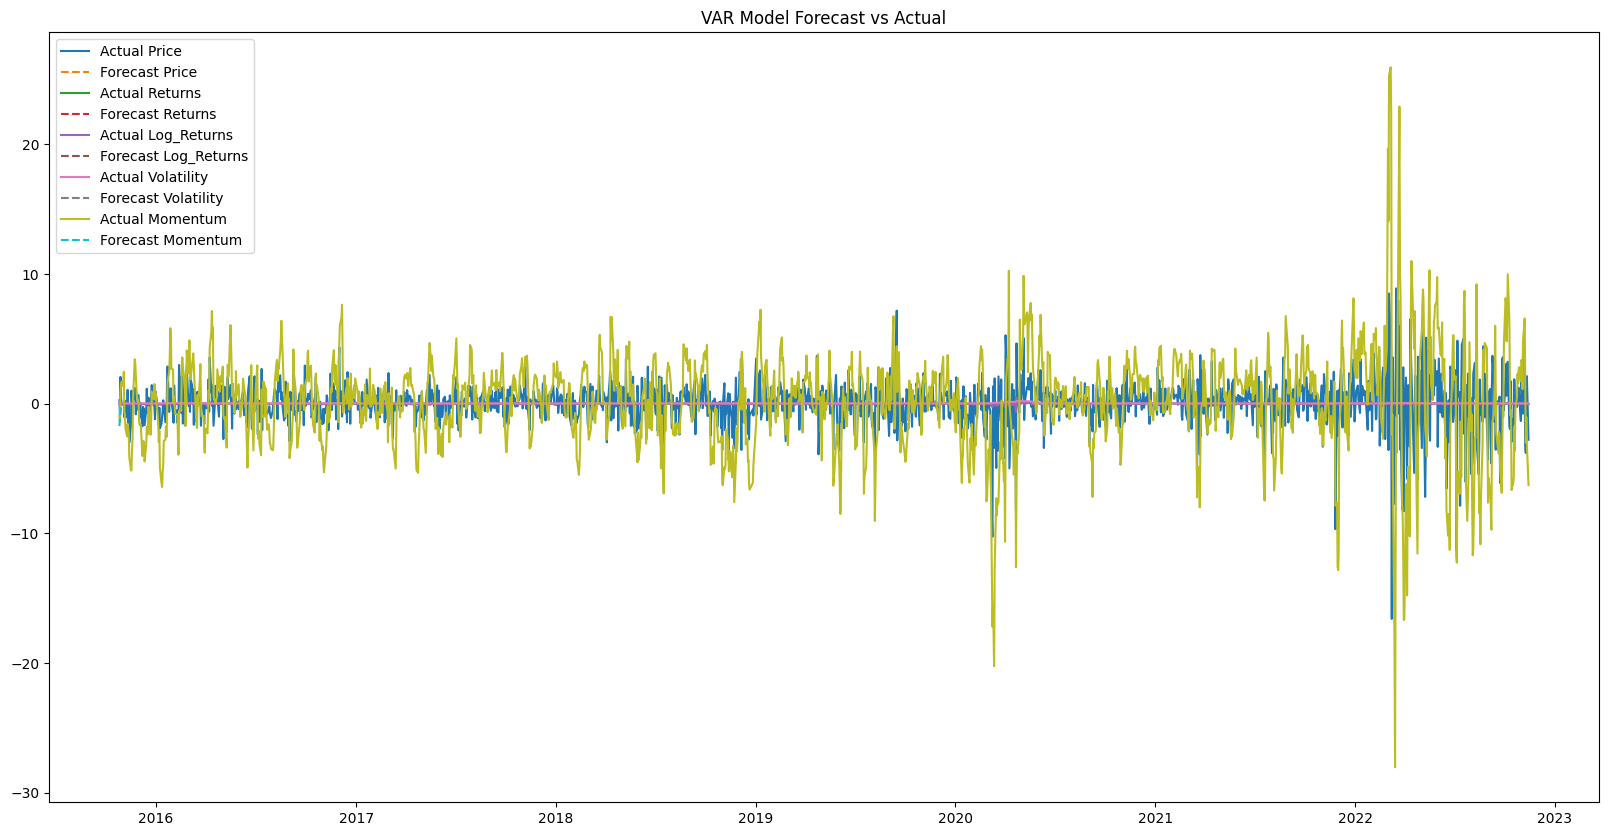

In [12]:
# Plotting actual vs predicted values for model evaluation
def plot_forecast_vs_actual(train, test, forecast_df):
    plt.figure(figsize=(20, 10))
    for col in test.columns:
        plt.plot(test.index, test[col], label=f'Actual {col}')
        forecast_index = pd.date_range(start=train.index[-1], periods=len(forecast_df)+1, freq='B')[1:]
        plt.plot(forecast_index, forecast_df[col], label=f'Forecast {col}', linestyle='--')
    plt.legend()
    plt.title("VAR Model Forecast vs Actual")
    plt.show()
# Plotting and evaluating
plot_forecast_vs_actual(train, test, forecast_df)



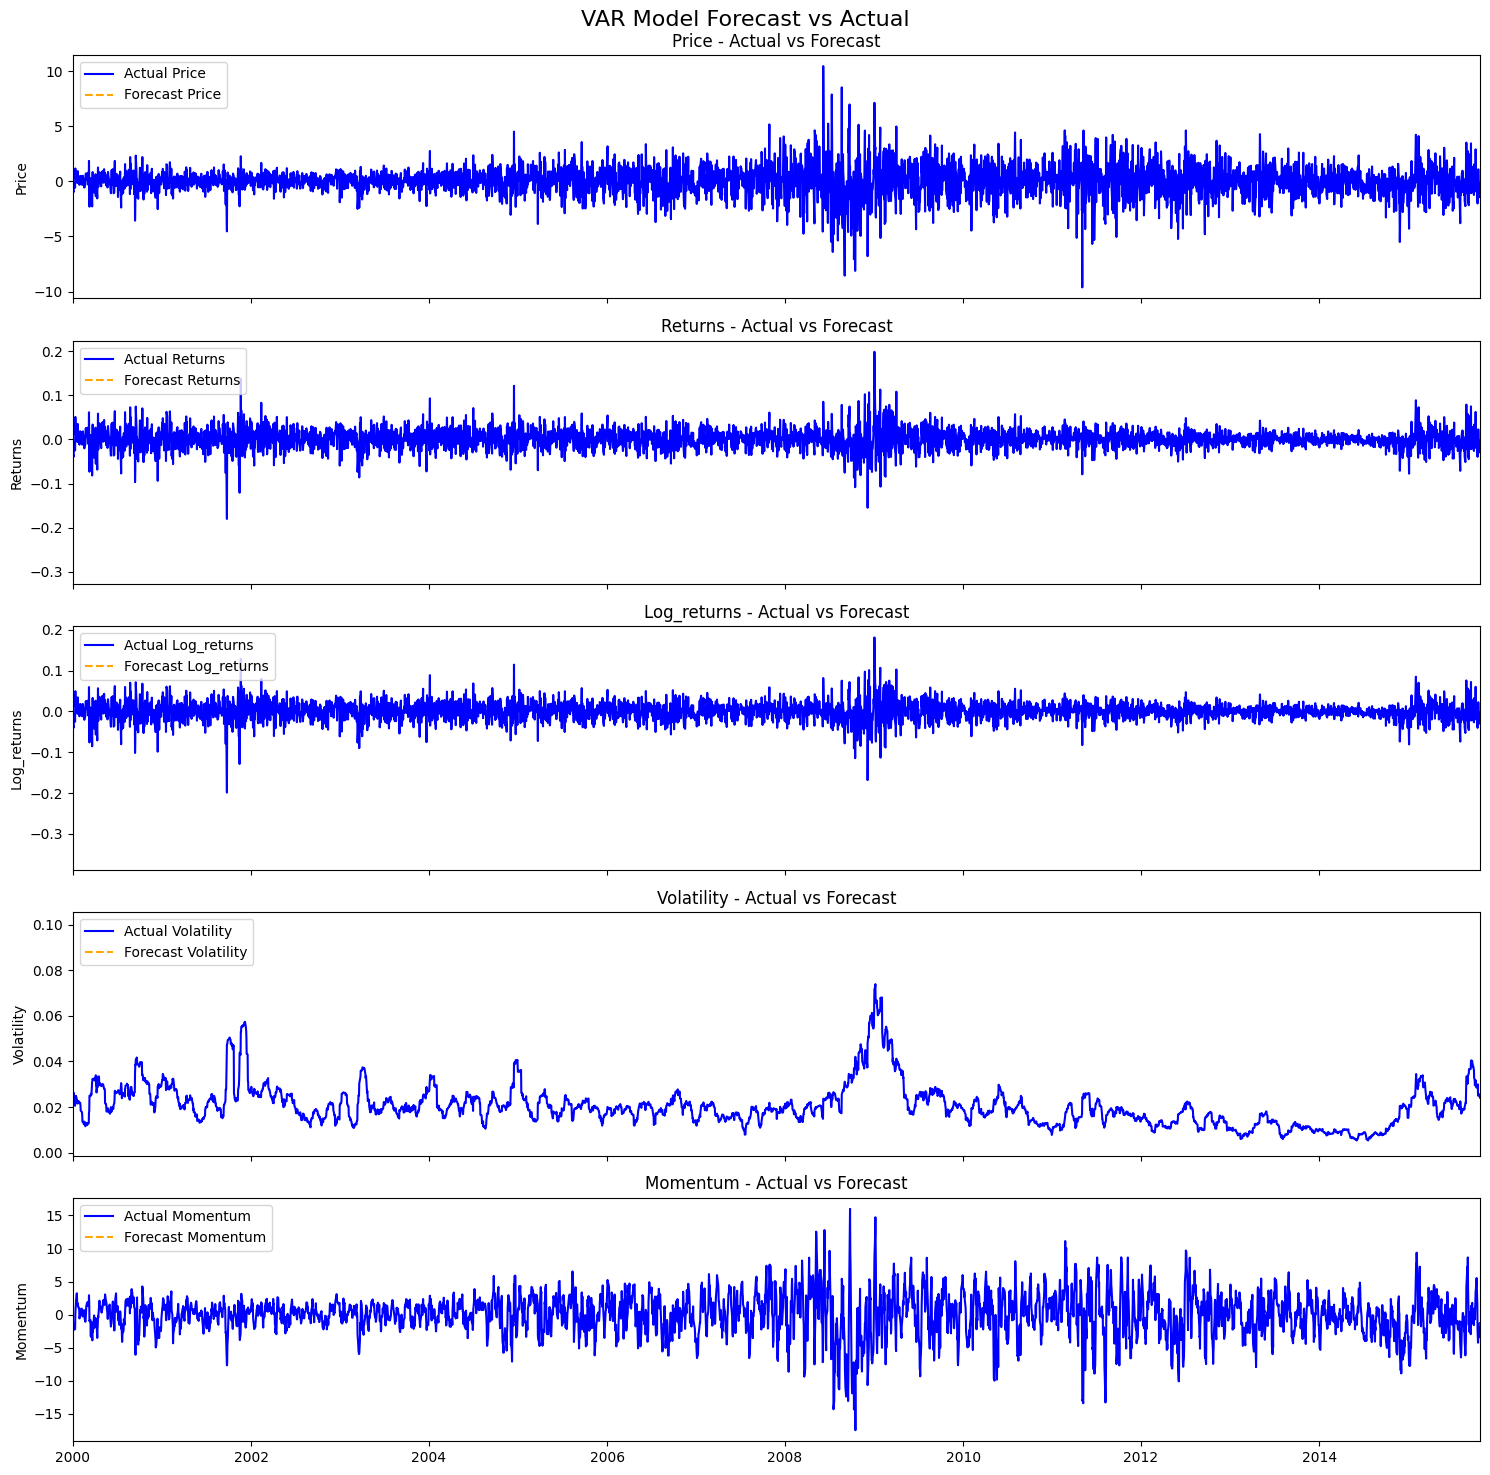

In [13]:
train_data = train

variables = train_data.columns  # ['price', 'returns', 'log_returns', 'volatility', 'Momentum']
num_vars = len(variables)

fig, axes = plt.subplots(num_vars, 1, figsize=(15, num_vars * 3), sharex=True)

for i, var in enumerate(variables):
    # Plot actual values
    axes[i].plot(train_data.index, train_data[var], label=f'Actual {var.capitalize()}', color='blue')
    
    # Plot forecasted values (shifted to match the forecast period)
    forecast_index = pd.date_range(start=train_data.index[-1], periods=len(forecast_df)+1, freq='B')[1:]  # Assuming business day frequency
    axes[i].plot(forecast_index, forecast_df[var], label=f'Forecast {var.capitalize()}', linestyle='--', color='orange')

    # Add legend and labels
    axes[i].legend(loc='upper left')
    axes[i].set_title(f'{var.capitalize()} - Actual vs Forecast')
    axes[i].set_ylabel(var.capitalize())

# Set a limit for the x-axis if needed to zoom in on recent data
axes[-1].set_xlim(pd.Timestamp('2000-01-01'), train_data.index[-1])

# Improve spacing and layout
fig.tight_layout()
fig.suptitle("VAR Model Forecast vs Actual", fontsize=16)
fig.subplots_adjust(top=0.95)  # Adjust to fit the suptitle

# Show the plot
plt.show()



#### Evaluate the Model

In [15]:
# Model evaluation function with extended metrics
def evaluate_model(test, forecast_df, recency_window=5):
    evaluation_metrics = {}
    forecast_df = forecast_df.iloc[:len(test)]

    for col in test.columns:
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(test[col].iloc[:len(forecast_df)], forecast_df[col]))
        
        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Recency RMSE (last 'recency_window' points)
        recent_rmse = np.sqrt(mean_squared_error(test[col].iloc[-recency_window:], forecast_df[col].iloc[-recency_window:]))

        evaluation_metrics[col] = {
            'Root Mean Squared Error ': rmse,
            'Mean Absolute Error ': mae,
            'Mean Absolute Percentage Error': mape,
            'Recency RMSE': recent_rmse
        }
        
        # Print the metrics
        print(f"Metrics for {col}:")
        print(f"  Root Mean Squared Error: {rmse}")
        print(f"  Mean Absolute Error: {mae}")
        print(f"  Mean Absolute Percentage Error: {mape}")
        print(f"  Recency RMSE (last {recency_window} values): {recent_rmse}\n")
        
    return evaluation_metrics

rmses = evaluate_model(test, forecast_df)

Metrics for Price:
  Root Mean Squared Error: 1.060092175712823
  Mean Absolute Error: 0.7802967084883895
  Mean Absolute Percentage Error: 1.0381569822023344
  Recency RMSE (last 5 values): 2.7173292360332493

Metrics for Returns:
  Root Mean Squared Error: 0.023087422452921808
  Mean Absolute Error: 0.01686498673242295
  Mean Absolute Percentage Error: 1.106487422219378
  Recency RMSE (last 5 values): 0.028224457133764154

Metrics for Log_Returns:
  Root Mean Squared Error: 0.02284195009836957
  Mean Absolute Error: 0.016754333699686697
  Mean Absolute Percentage Error: 1.0411852670404247
  Recency RMSE (last 5 values): 0.028464374961006466

Metrics for Volatility:
  Root Mean Squared Error: 0.0009208365323540055
  Mean Absolute Error: 0.0007662400160817137
  Mean Absolute Percentage Error: 0.03087243007819427
  Recency RMSE (last 5 values): 0.004054080569418284

Metrics for Momentum:
  Root Mean Squared Error: 1.4187076299932422
  Mean Absolute Error: 1.2753374333909808
  Mean Absol

In [18]:
# Saving the model
def save_model(var_model, model_path='../model/var_model.joblib'):
    joblib.dump(var_model, model_path)
    print(f"Model saved to {model_path}")

# Save the model
save_model(var_model)

Model saved to C:/Users/elbet/OneDrive/Desktop/Ten/week-10/Change-point-analysis-and-statistical-modelling-of-time-series-data/var_model.joblib
